In [1]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

from utils.plots import *
from utils.funcs import *


from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

In [73]:
# Parameters:

N_V = 20
T = 30
N_H = 3
device = 'cpu'
n_rtrbms = 1
n_batches = 500

In [74]:
sparsity = np.arange(0, .9, .1, dtype=np.float32)
W_list = []
generated = []
trained = []

for _ in range(n_rtrbms):
    W = 2 * np.random.rand(N_H, N_V) - 1
    U = 2 * np.random.rand(N_H, N_H) - 1
    for sp in sparsity:
        idx = np.random.randint(low=0, high=int(N_V*N_H), size=(int(sp*N_V*N_H),))
        for x,y in zip(np.unravel_index(idx, W.shape)[0], np.unravel_index(idx, W.shape)[1]):
            W[x, y] = 0
        W_list += [torch.tensor(W, device=device)]

        b_init = torch.zeros(1, N_H, dtype=torch.float)
        b_V = torch.zeros(1, N_V, dtype=torch.float)
        b_H = torch.zeros(1, N_H, dtype=torch.float)

        data = torch.zeros(N_V, T, dtype=torch.float)

        rtrbm = RTRBM(data, N_H=N_H, device='cpu')

        rtrbm.W = torch.tensor(W, device=device, dtype=torch.float)
        rtrbm.U = torch.tensor(U, device=device, dtype=torch.float)
        rtrbm.b_init = b_init
        rtrbm.b_V = b_V
        rtrbm.b_H = b_H

        data = torch.zeros(N_V, T, n_batches)
        rt = torch.zeros(N_H, T, n_batches)
        for batch in tqdm(range(n_batches)):
            v_start = (torch.rand(N_V) > 0.2)*1.0
            data[:, :, batch], rt[:, :, batch] = rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)

        rtrbm_nobias = RTRBM_nobias(data, N_H=N_H, device='cpu')
        rtrbm_nobias.learn(n_epochs=2000, lr=1e-3, lr_end=1e-5, start_decay=200, batchsize=100, mom=0.9, wc=0.0002)

        generated += [rtrbm]
        trained += [rtrbm_nobias]


100%|██████████| 2000/2000 [1:01:10<00:00,  1.84s/it]


<AxesSubplot:>

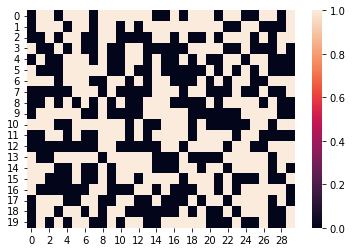

In [100]:
sns.heatmap(data[:,:,0])

Text(0, 0.5, 'generated sparsity')

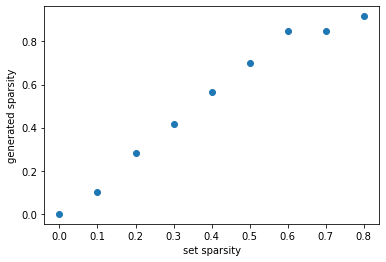

In [92]:
res_sparsity = []
for gen, tr in zip(generated, trained):
    res_sparsity += [torch.sum(gen.W==0) / 60]

plt.plot(sparsity, res_sparsity, 'o')
plt.xlabel('set sparsity')
plt.ylabel('generated sparsity')

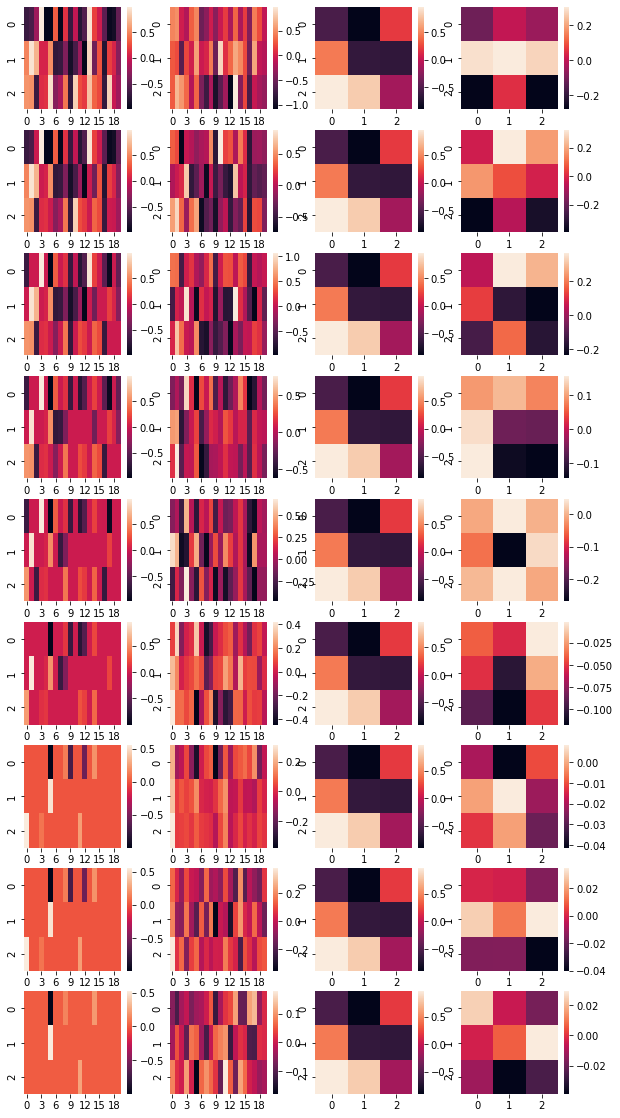

In [77]:
fig, axes = plt.subplots(9, 4, figsize=(10, 20))

for i, ax in enumerate(axes):
    sns.heatmap(generated[i].W, ax=ax[0])
    sns.heatmap(trained[i].W, ax=ax[1])
    sns.heatmap(generated[i].U, ax=ax[2])
    sns.heatmap(trained[i].U, ax=ax[3])

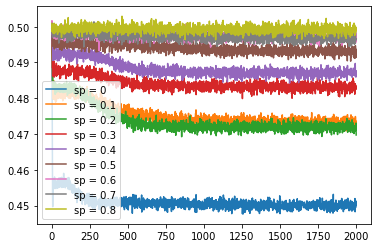

In [79]:
for tr in trained:
    plt.plot(tr.errors)

plt.legend(['sp = 0', 'sp = 0.1', 'sp = 0.2', 'sp = 0.3', 'sp = 0.4', 'sp = 0.5', 'sp = 0.6', 'sp = 0.7', 'sp = 0.8','sp = 0.9'])

D:\Programs\anaconda\envs\rtrbm\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
D:\Programs\anaconda\envs\rtrbm\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0, 0.5, 'final reconstruction error')

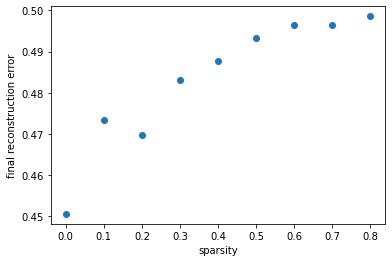

In [85]:
final_rec_error = []
for tr in trained:
    final_rec_error += [tr.errors[-1]]

plt.plot(sparsity, final_rec_error, 'o')
plt.xlabel('sparsity')
plt.ylabel('final reconstruction error')

In [94]:
shuffle_idx_possibilities = [[0, 1, 2], [0, 2, 1], [1, 2, 0], [1, 0, 2], [2, 1, 0], [2, 0, 1]]

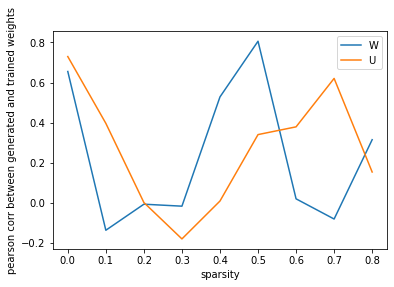

In [98]:
rW = []
rU = []
for gen, tr in zip(generated, trained):

    W_original = gen.W
    W_train = tr.W
    U_original = gen.U
    U_train = tr.U

    for i, shuffle_idx in enushuffle_idx_possibilities:
        W_train = W_train[shuffle_idx, :]
        U_train = U_train[shuffle_idx, :]
        U_train = U_train[:, shuffle_idx]

        _, _, r_W, _, _ = linregress(W_original.ravel(), W_train.ravel())
        _, _, r_U, _, _ = linregress(U_original.ravel(), U_train.ravel())

    rW += [r_W]
    rU += [r_U]

plt.plot(sparsity, rW, sparsity, rU)
plt.xlabel('sparsity')
plt.ylabel('pearson corr between generated and trained weights')
plt.legend(['W','U'])

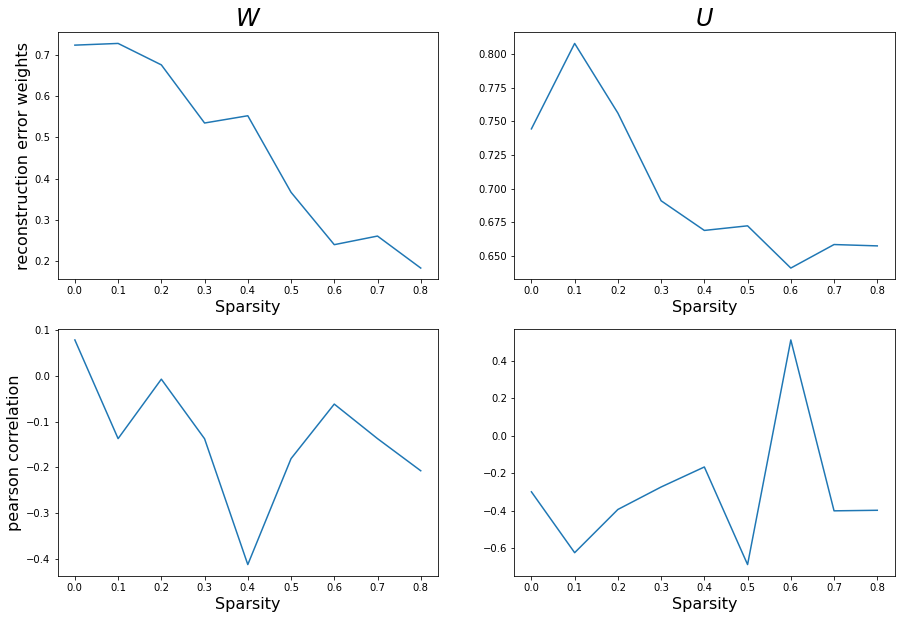

In [116]:
W_err = []
U_err = []
rW = []
rU = []

for gen, tr in zip(generated, trained):

    W_original = gen.W
    W_train = tr.W
    U_original = gen.U
    U_train = tr.U

    W_error = torch.zeros(6)
    U_error = torch.zeros(6)
    r_W = torch.zeros(6)
    r_U = torch.zeros(6)
    for i, shuffle_idx in enumerate(shuffle_idx_possibilities):

        W_train_shuffled = W_train[shuffle_idx, :]
        U_train_shuffled = U_train[shuffle_idx, :]
        U_train_shuffled = U_train[:, shuffle_idx]

        W_error[i] = RMSE(W_original, W_train_shuffled)
        U_error[i] = RMSE(U_original,U_train_shuffled)

        _, _, r_W[i], _, _ = linregress(W_original.ravel(), W_train_shuffled.ravel())
        _, _, r_U[i], _, _ = linregress(U_original.ravel(), U_train_shuffled.ravel())

    best_idx = torch.argmax(W_error)

    W_err += [W_error[best_idx]]
    U_err += [U_error[best_idx]]
    rW += [r_W[best_idx]]
    rU += [r_U[best_idx]]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].plot(sparsity, W_err)
axes[0, 1].plot(sparsity, U_err)
axes[1, 0].plot(sparsity, rW)
axes[1, 1].plot(sparsity, rU)

axes[0, 0].set_ylabel('reconstruction error weights', fontsize=16)
axes[1, 0].set_ylabel('pearson correlation', fontsize=16)
axes[0, 0].set_title('$W$', fontsize=24)
axes[0, 1].set_title('$U$', fontsize=24)
for ax in axes.ravel():
    ax.set_xlabel('Sparsity', fontsize=16)

In [102]:
torch.save([[generated], [trained]], r"D:\OneDrive\RU\Intern\rtrbm_master\results\Continuous Weights Getting More Sparse\one_run")